# Detección de anomalías en un marco de auditoría continua

## 8. Datos desbalanceados - Modelos no supervisados

### 8.1. Split del dataset

Split del dataset para reservar un conjunto de datos para validación posterior al entrenamiento y desarrollo de los modelos.

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import os
import time
import joblib
import matplotlib.pyplot as plt

In [2]:
# Filtro de warnings.
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Carga del dataset.
os.chdir('..')
df = pd.read_csv('df_preprocessed.csv')
df.head()

,day,hour,amount,idOrig,oldbalanceOrig,newbalanceOrig,idDest,oldbalanceDest,newbalanceDest,Cash_in,Cash_out,Debit,Payment,Transfer,isFraud,isFlaggedFraud
0,1,1,9839.64,0,170136.0,160296.36,6353307,0.0,0.0,0,0,0,1,0,0,0
1,1,1,1864.28,1,21249.0,19384.72,6353308,0.0,0.0,0,0,0,1,0,0,0
2,1,1,181.00,2,181.0,0.00,6353309,0.0,0.0,0,0,0,0,1,1,0
3,1,1,181.00,3,181.0,0.00,6353310,21182.0,0.0,0,1,0,0,0,1,0
4,1,1,11668.14,4,41554.0,29885.86,6353311,0.0,0.0,0,0,0,1,0,0,0


In [4]:
# Split del dataset para reservar un conjunto de validación.
from sklearn.model_selection import train_test_split
df_training, df_validation = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True, stratify = np.array(df['isFraud']))

In [5]:
# Control de frecuencias de clases.
print('Proporcion de clases para dataset de training: %.4f' % (df_training['isFraud'].value_counts()[1] / df_training['isFraud'].value_counts()[0]))
print('Proporcion de clases para dataset de validación: %.4f' % (df_validation['isFraud'].value_counts()[1] / df_validation['isFraud'].value_counts()[0]))

Proporcion de clases para dataset de training: 0.0013
Proporcion de clases para dataset de validación: 0.0013


### 8.2. Clustering - K-Means

https://scikit-learn.org/stable/modules/clustering.html#clustering

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans

#### 8.2.1. Ingeniería de predictores

Se evaluan los métodos de estandarización y normalización de atributos.

Se evalua la eliminación de algunos atributos (día y hora de la operación y códigos de identificación de originante y destinatario, en estos dos últimos casos considerando la naturaleza del modelo).

In [15]:
# Importación de librerías.
import json
from datetime import datetime
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, Normalizer, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, accuracy_score
from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.early_stop import no_progress_loss
  
# Definción de la función objetivo.
def objective_func(search_space):
    
    global counter, scorings
    
    start_time = time.time()
    counter += 1
    
    scaler = search_space['scaler']
    selected_columns = search_space['selected_columns']

    X_train_dropped = X_train.drop(list(selected_columns), axis = 1)
    X_test_dropped = X_test.drop(list(selected_columns), axis = 1)    

    if scaler is None:
        X_train_scaled = X_train_dropped
        X_test_scaled = X_test_dropped
    else:
        X_train_scaled = scaler.fit_transform(X_train_dropped)
        X_train_scaled = pd.DataFrame(X_train_scaled)
        X_test_scaled = scaler.fit_transform(X_test_dropped)
        X_test_scaled = pd.DataFrame(X_test_scaled)
    
    kmeans = KMeans(random_state = 42, n_clusters = 2)
    kmeans = kmeans.fit(X_train_scaled)
    y_pred = kmeans.predict(X_test_scaled)
  
    if sum(y_pred) <= (len(y_pred) - sum(y_pred)):
        None
    else:
        for i, j in enumerate(y_pred):
            if j == 0:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    
    f1 = f1_score(y_pred = y_pred, y_true = y_test)

    loss = 1 - f1
    
    scorings.append({'trial': counter,
                     'search_space' : search_space,
                     'scorings' : {'Recall': recall_score(y_test, y_pred),
                                   'Precision': precision_score(y_test, y_pred),
                                   'AUC': roc_auc_score(y_test, y_pred),
                                   'Accuracy': accuracy_score(y_test, y_pred),
                                   'F1-Score': f1}
                    }
                   )    
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (counter, loss, elapsed_time))

    return loss

# Función para la impresión de resultados.
def hyperopt_printer(trials):
    print('\nBest Trial:')
    print('Trial ID :', trials.best_trial['tid'])
    print('Loss :', trials.best_trial['result']['loss'])
    print('Params :', space_eval(search_space, best_params), end = '\n\n')

# Función para exportación de resultados a formato JSON.
def json_export(scorings):
    try:
        os.mkdir('hyperopt_optimizations')
    except:
        None

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    path = os.getcwd() + '\hyperopt_optimizations\\'
    filename = 'Opt_' + dt_string + '.json'

    f = open(path + filename, 'w')
    json.dump(scorings, f)
    f.close()
    print('Json file: ' + dt_string + '.json', end = '\n\n')

# Función para la obtención de resultados en formato tabla para visualizar scorings y desvios estándar.
def scorings_to_df(scorings):
    scorings_df = pd.DataFrame(columns = list(scorings[0]['scorings'].keys()))
    for scoring in scorings:
        scorings_df = scorings_df.append(scoring['scorings'], ignore_index = True)

    print('Scoring details:', end = '\n\n')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
        print(scorings_df)

    return scorings_df

In [18]:
# Subconjunto de registros.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.99, random_state = 42)
splitter = StratifiedShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 42)

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,:]['isFraud']
      
for train, test in splitter.split(X, y):
    X_train = X.iloc[train, :]
    X_test = X.iloc[test, :]
    y_train = y.iloc[train]
    y_test = y.iloc[test]

# Combinaciones de columnas.
import itertools
items =  ['day', 'hour', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']
combinations = []
for item in range(0, len(items) + 1):
    for subset in itertools.combinations(items, item):
        combinations.append(list(subset))

# Definición del espacio / dominio de parámetros.
scalers = [None, MinMaxScaler((0, 1)), MinMaxScaler((-1, 1)), MaxAbsScaler(), Normalizer(), StandardScaler(), RobustScaler()]
search_space = {'selected_columns' : hp.choice('selected_columns', combinations),
                'scaler' : hp.choice('scaler', scalers)
               }

# Implementación de Hyperopt
counter = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(100), 
                   rstate = rstate)

Trial: 0 | Loss: 0.9964 | Elapsed_time: 13.7731 seconds
Trial: 1 | Loss: 0.9962 | Elapsed_time: 10.5102 seconds                          
Trial: 2 | Loss: 0.9962 | Elapsed_time: 11.6043 seconds                          
Trial: 3 | Loss: 0.9962 | Elapsed_time: 11.0505 seconds                          
Trial: 4 | Loss: 0.9962 | Elapsed_time: 11.0177 seconds                          
Trial: 5 | Loss: 0.9999 | Elapsed_time: 11.7790 seconds                          
Trial: 6 | Loss: 0.9961 | Elapsed_time: 10.8156 seconds                          
Trial: 7 | Loss: 0.9997 | Elapsed_time: 26.6380 seconds                          
Trial: 8 | Loss: 0.9964 | Elapsed_time: 13.6938 seconds                          
Trial: 9 | Loss: 0.9962 | Elapsed_time: 10.1803 seconds                          
Trial: 10 | Loss: 0.9980 | Elapsed_time: 27.0004 seconds                          
Trial: 11 | Loss: 1.0000 | Elapsed_time: 11.0388 seconds                          
Trial: 12 | Loss: 0.9962 | Elapsed_time:

In [20]:
# Impresión de resultados.
hyperopt_printer(trials)
scorings_df = scorings_to_df(scorings)
print()
print(scorings)


Best Trial:
Trial ID : 22
Loss : 0.9525382997897267
Params : {'scaler': RobustScaler(), 'selected_columns': ('day', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest')}

Scoring details:

      Recall  Precision       AUC  Accuracy  F1-Score
0   0.687164   0.001819  0.599902  0.512865  0.003629
1   0.516526   0.001895  0.582403  0.648109  0.003775
2   0.516526   0.001895  0.582403  0.648109  0.003775
3   0.516526   0.001895  0.582403  0.648109  0.003775
4   0.516526   0.001895  0.582403  0.648109  0.003775
5   0.006149   0.000036  0.393196  0.779245  0.000072
6   0.124520   0.001980  0.521688  0.917831  0.003897
7   0.007686   0.000173  0.475054  0.941216  0.000337
8   0.687164   0.001819  0.599902  0.512865  0.003629
9   0.516526   0.001895  0.582403  0.648109  0.003775
10  0.045350   0.001004  0.493526  0.940546  0.001965
11  0.000000   0.000000  0.330404  0.659956  0.000000
12  0.516526   0.001895  0.582403  0.648109  0.003775
13  0.006149   0.000159  0.478155  0.948942

#### 8.2.2. Optimización de hiperparámetros

Best Trial:
Trial ID : 22
Loss : 0.9525382997897267
Params : {'scaler': RobustScaler(), 'selected_columns': ('day', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest')}

In [10]:
# Importación de librerías.
import json
from datetime import datetime
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, accuracy_score
from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.early_stop import no_progress_loss
from math import log, ceil
  
# Definción de la función objetivo.
def objective_func(search_space):
    
    global counter, scorings
    
    start_time = time.time()
    counter += 1
    
    scaler = search_space['scaler']
    selected_columns = search_space['selected_columns']
    search_space['params']['max_iter'] = ceil(search_space['params']['max_iter'])
    search_space['params']['n_init'] = ceil(search_space['params']['n_init'])

    X_train_dropped = X_train.drop(list(selected_columns), axis = 1)
    X_test_dropped = X_test.drop(list(selected_columns), axis = 1)    

    if scaler is None:
        X_train_scaled = X_train_dropped
        X_test_scaled = X_test_dropped
    else:
        X_train_scaled = scaler.fit_transform(X_train_dropped)
        X_train_scaled = pd.DataFrame(X_train_scaled)
        X_test_scaled = scaler.fit_transform(X_test_dropped)
        X_test_scaled = pd.DataFrame(X_test_scaled)
    
    kmeans = KMeans(n_clusters = 2, **search_space['params'])
    kmeans = kmeans.fit(X_train_scaled)
    y_pred = kmeans.predict(X_test_scaled)
  
    if sum(y_pred) <= (len(y_pred) - sum(y_pred)):
        None
    else:
        for i, j in enumerate(y_pred):
            if j == 0:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    
    f1 = f1_score(y_pred = y_pred, y_true = y_test)

    loss = 1 - f1
    
    scorings.append({'trial': counter,
                     'search_space' : search_space,
                     'scorings' : {'Recall': recall_score(y_test, y_pred),
                                   'Precision': precision_score(y_test, y_pred),
                                   'AUC': roc_auc_score(y_test, y_pred),
                                   'Accuracy': accuracy_score(y_test, y_pred),
                                   'F1-Score': f1}
                    }
                   )    
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (counter, loss, elapsed_time))

    return loss

# Función para la impresión de resultados.
def hyperopt_printer(trials):
    print('\nBest Trial:')
    print('Trial ID :', trials.best_trial['tid'])
    print('Loss :', trials.best_trial['result']['loss'])
    print('Params :', space_eval(search_space, best_params), end = '\n\n')

# Función para exportación de resultados a formato JSON.
def json_export(scorings):
    try:
        os.mkdir('hyperopt_optimizations')
    except:
        None

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    path = os.getcwd() + '\hyperopt_optimizations\\'
    filename = 'Opt_' + dt_string + '.json'

    f = open(path + filename, 'w')
    json.dump(scorings, f)
    f.close()
    print('Json file: ' + dt_string + '.json', end = '\n\n')

# Función para la obtención de resultados en formato tabla para visualizar scorings y desvios estándar.
def scorings_to_df(scorings):
    scorings_df = pd.DataFrame(columns = list(scorings[0]['scorings'].keys()))
    for scoring in scorings:
        scorings_df = scorings_df.append(scoring['scorings'], ignore_index = True)

    print('Scoring details:', end = '\n\n')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
        print(scorings_df)

    return scorings_df

In [11]:
# Subconjunto de registros.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.99, random_state = 42)
splitter = StratifiedShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 42)

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,:]['isFraud']
      
for train, test in splitter.split(X, y):
    X_train = X.iloc[train, :]
    X_test = X.iloc[test, :]
    y_train = y.iloc[train]
    y_test = y.iloc[test]

# Definición del espacio / dominio de parámetros.
selected_columns = ['day', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest']
search_space = {'selected_columns' : selected_columns,
                'scaler' : RobustScaler(),
                'params' : {'init' : hp.choice('init', ['k-means++', 'random']),
                            'n_init' : hp.lognormal('n_init', log(10), log(1.5)),
                            'max_iter' : hp.lognormal('max_iter', log(300), log(5)),
                            'tol' : hp.normal('tol', 0.0001, 0.00001),
                            'random_state' : 42,
                            'n_jobs' : -1,
                            'algorithm' : hp.choice('algorithm', ['full', 'elkan'])
                           }
               }

# Implementación de Hyperopt
counter = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(100), 
                   rstate = rstate)

Trial: 0 | Loss: 0.9525 | Elapsed_time: 26.6138 seconds
Trial: 1 | Loss: 0.9525 | Elapsed_time: 33.6193 seconds                          
Trial: 2 | Loss: 0.9525 | Elapsed_time: 16.9897 seconds                          
Trial: 3 | Loss: 0.9525 | Elapsed_time: 60.6854 seconds                          
Trial: 4 | Loss: 0.9525 | Elapsed_time: 28.1646 seconds                            
Trial: 5 | Loss: 0.9525 | Elapsed_time: 27.9104 seconds                            
Trial: 6 | Loss: 0.9525 | Elapsed_time: 74.7955 seconds                          
Trial: 7 | Loss: 0.9525 | Elapsed_time: 7.5863 seconds                             
Trial: 8 | Loss: 0.9525 | Elapsed_time: 26.2873 seconds                            
Trial: 9 | Loss: 0.9525 | Elapsed_time: 17.7822 seconds                          
Trial: 10 | Loss: 0.9525 | Elapsed_time: 24.4402 seconds                          
Trial: 11 | Loss: 0.9629 | Elapsed_time: 7.1463 seconds                           
Trial: 12 | Loss: 0.9525 | Elaps

In [12]:
# Impresión de resultados.
hyperopt_printer(trials)
scorings_df = scorings_to_df(scorings)
print()
print(scorings)


Best Trial:
Trial ID : 24
Loss : 0.9479891140006048
Params : {'params': {'algorithm': 'full', 'init': 'k-means++', 'max_iter': 0.749941889542941, 'n_init': 13.707328356680836, 'n_jobs': -1, 'random_state': 42, 'tol': 6.031336125338633e-05}, 'scaler': RobustScaler(), 'selected_columns': ('day', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest')}

Scoring details:

      Recall  Precision       AUC  Accuracy  F1-Score
0   0.060723   0.038955  0.529393  0.996854  0.047462
1   0.060723   0.038955  0.529393  0.996854  0.047462
2   0.060723   0.038955  0.529393  0.996854  0.047462
3   0.060723   0.038955  0.529393  0.996854  0.047462
4   0.060723   0.038955  0.529393  0.996854  0.047462
5   0.060723   0.038955  0.529393  0.996854  0.047462
6   0.060723   0.038955  0.529393  0.996854  0.047462
7   0.060723   0.038955  0.529393  0.996854  0.047462
8   0.060723   0.038955  0.529393  0.996854  0.047462
9   0.060723   0.038955  0.529393  0.996854  0.047462
10  0.060723   0.038955  0

#### 8.2.3. Evaluación sobre el conjunto de validación

Best Trial:
Trial ID : 24
Loss : 0.9479891140006048
Params : {'params': {'algorithm': 'full', 'init': 'k-means++', 'max_iter': 0.749941889542941, 'n_init': 13.707328356680836, 'n_jobs': -1, 'random_state': 42, 'tol': 6.031336125338633e-05}, 'scaler': RobustScaler(), 'selected_columns': ('day', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest')}

In [6]:
# Importación de librerías.
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, accuracy_score
from math import ceil

# Evaluación con el conjunto de validación.
search_space = {'params': {'algorithm': 'full', 
                           'init': 'k-means++', 
                           'max_iter': ceil(0.749941889542941), 
                           'n_init': ceil(13.707328356680836), 
                           'n_jobs': -1, 
                           'random_state': 42, 
                           'tol': 6.031336125338633e-05}, 
                'scaler': RobustScaler(), 
                'selected_columns': ['day', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest']}

selected_columns = search_space['selected_columns']
scaler = search_space['scaler']

X_train = df_training.drop(selected_columns, axis = 1)
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
y_train = df_training['isFraud']

X_test = df_validation.drop(selected_columns, axis = 1)
X_test = scaler.fit_transform(X_test)
y_test = df_validation['isFraud']

kmeans = KMeans(n_clusters = 2, **search_space['params'])
kmeans = kmeans.fit(X_train)
y_pred = kmeans.predict(X_test)
  
if sum(y_pred) <= (len(y_pred) - sum(y_pred)):
    None
else:
    for i, j in enumerate(y_pred):
        if j == 0:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    
print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.0651
Precision: 0.0431
AUC: 0.5316
Accuracy: 0.9969
F1-Score: 0.0519


In [7]:
# Reporte Precision, Recall, F1.
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names = ['Not Fraud', 'Fraud'], digits = 4))

              precision    recall  f1-score   support

   Not Fraud     0.9988    0.9981    0.9985   1270881
       Fraud     0.0431    0.0651    0.0519      1643

    accuracy                         0.9969   1272524
   macro avg     0.5210    0.5316    0.5252   1272524
weighted avg     0.9976    0.9969    0.9972   1272524



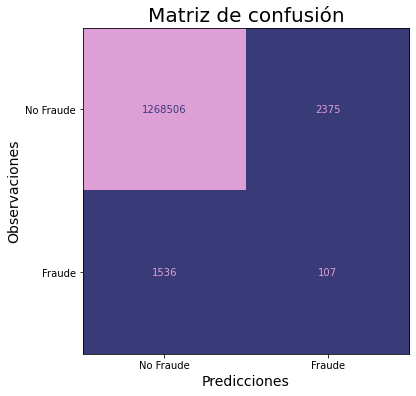

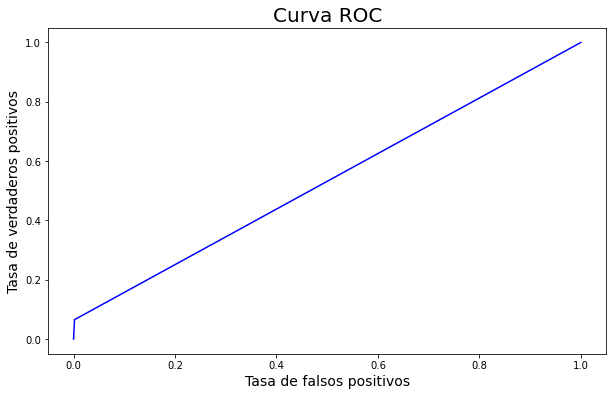

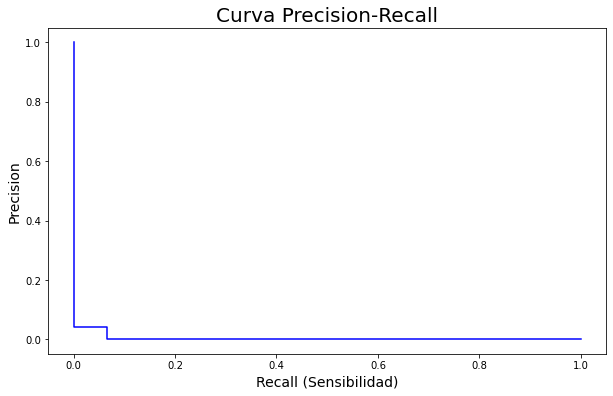

In [8]:
# Exportación a png.
from export import export_png
export_png(filename = 'kmeans', y_test = y_test, y_pred = y_pred)

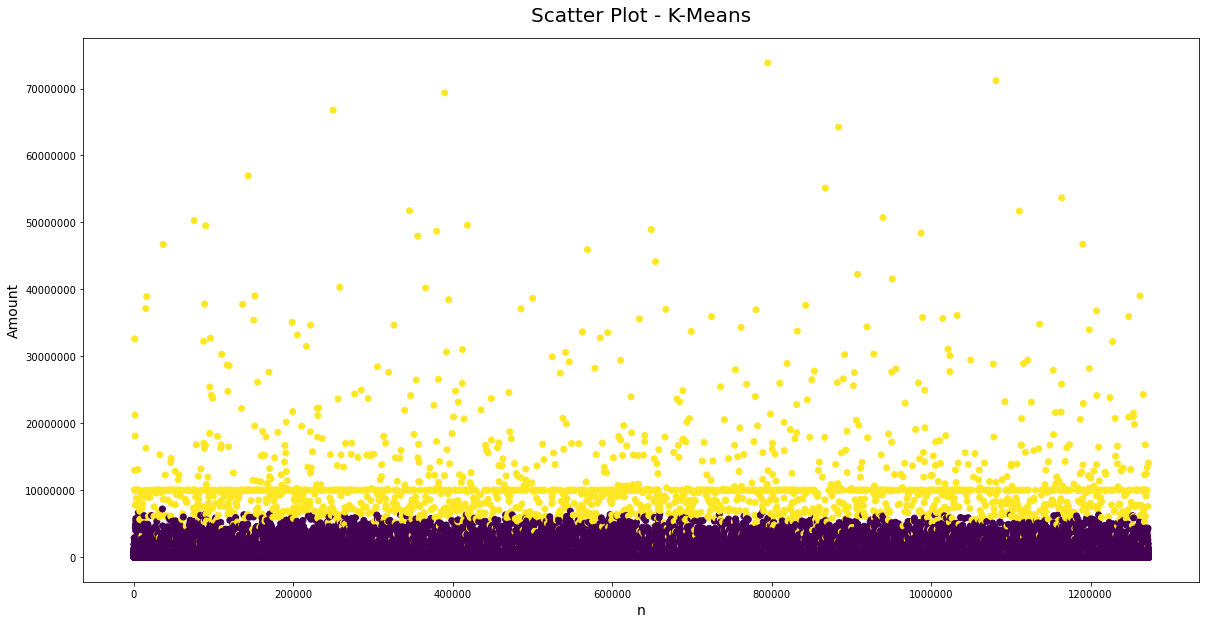

In [17]:
# Scatter plot con predicciones realizadas por K-Means.
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

df_disp = pd.DataFrame({'amount' : df_validation.amount, 'prediction' : y_pred})
df_disp = df_disp.reset_index()
df_disp = df_disp

fig, ax = plt.subplots(figsize = (20, 10))
fig = plt.scatter(x = df_disp.index, y = df_disp.amount, c = df_disp.prediction)
fig = plt.title(label = 'Scatter Plot - K-Means', fontdict = {'fontsize' : 20}, y = 1.02)
ax.set_xlabel('n', fontdict = {'fontsize' : 14})
ax.set_ylabel('Amount', fontdict = {'fontsize' : 14})
ax.xaxis.set_major_formatter(FormatStrFormatter('%i'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%i'))
plt.show()

### 8.3. Detección de anomalías utilizando la Ley de Benford

https://towardsdatascience.com/frawd-detection-using-benfords-law-python-code-9db8db474cf8

https://github.com/eleprocha/Benford-s-Law_python_code/blob/master/code

In [6]:
# Configuración de número de decimales.
pd.options.display.float_format = '{:.2f}'.format

# Analisis exploratorio de datos.      
with pd.option_context('display.max_rows', None, 'display.max_columns', 10, 'display.width', 1000):
    print(df.describe().transpose())
print()
print(df.info())
print()
print(df.isnull().sum())

                    count       mean        std    min        25%        50%        75%          max
day            6362620.00      10.49       5.92   1.00       7.00      10.00      14.00        31.00
hour           6362620.00       8.37       4.56   1.00       6.00       8.00      11.00        24.00
amount         6362620.00  179861.90  603858.23   0.00   13389.57   74871.94  208721.48  92445516.64
idOrig         6362620.00 3175068.41 1834059.22   0.00 1586504.75 3174301.50 4763206.25   6353306.00
oldbalanceOrig 6362620.00  833883.10 2888242.67   0.00       0.00   14208.00  107315.18  59585040.37
newbalanceOrig 6362620.00  855113.67 2924048.50   0.00       0.00       0.00  144258.41  49585040.37
idDest         6362620.00 7275614.81  795239.09 571.00 6611227.00 7083926.00 7842574.25   9073899.00
oldbalanceDest 6362620.00 1100701.67 3399180.11   0.00       0.00  132705.66  943036.71 356015889.35
newbalanceDest 6362620.00 1224996.40 3674128.94   0.00       0.00  214661.44 1111909.25 356

In [7]:
# Función para el cálculo de frecuencias relativas.
def count_first_digit(data_str):
    mask = df[data_str] > 1.
    data = list(df[mask][data_str])
    for i in range(len(data)):
        while data[i] > 10:
            data[i] = data[i]/10
    first_digits = [int(x) for x in sorted(data)]
    unique = (set(first_digits)) # Lista con los valores unicos de la lista first_digits.
    data_count = []
    for i in unique:
        count = first_digits.count(i)
        data_count.append(count)
    total_count = sum(data_count)
    data_percentage = [(i / total_count) * 100 for i in data_count]
    return total_count, data_count, data_percentage

total_count, data_count, data_percentage = count_first_digit('amount')

In [8]:
# Porcentajes de la Ley de Benford.
BENFORD = [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6]

In [9]:
# Lista de recuentos esperados segun la Ley de Benford.
def get_expected_counts(total_count):
    global BENFORD
    return [round(p * total_count / 100) for p in BENFORD]

expected_counts = get_expected_counts(total_count)

In [10]:
# Impresión de resultados.
print('Total de registros:', total_count)
print('Recuento por digito:', *data_count)
print('Porcentaje por digito:', *data_percentage)
print('Recuento esperado por digito:', *expected_counts)

Total de registros: 6362487
Recuento por digito: 2134173 1302139 798406 526686 395748 334283 305911 287550 274247 3344
Porcentaje por digito: 33.54306264201404 20.465880716141346 12.548646464817924 8.277989408858517 6.2200205674290565 5.253967513018101 4.80804125808037 4.5194591360265255 4.310374229448327 0.05255806416578926
Recuento esperado por digito: 1915109 1119798 795311 617161 502636 426287 369024 324487 292674


In [11]:
# Prueba de similitud de valores en base al estadístico chi-cuadrado.
import math

# Función que devuelve un valor booleano de una prueba chi-cuadrado con 8 grados de libertad y un p-value de 0.05.
def chi_square_test(data_count, expected_counts):
    
    chi_square_stat = 0  # Estadistico chi-cuadrado.
    
    for data, expected in zip(data_count, expected_counts):
        chi_square = math.pow(data - expected, 2)
        chi_square_stat += chi_square / expected

    print("\nEstadistico prueba chi-cuadrado = {:.3f}".format(chi_square_stat))
    print("Valor critico de un p-valor de 0.05 es 15.51.")    
    return chi_square_stat < 15.51

chi_square_test(data_count, expected_counts)


Estadistico prueba chi-cuadrado = 126770.925
Valor critico de un p-valor de 0.05 es 15.51.


False

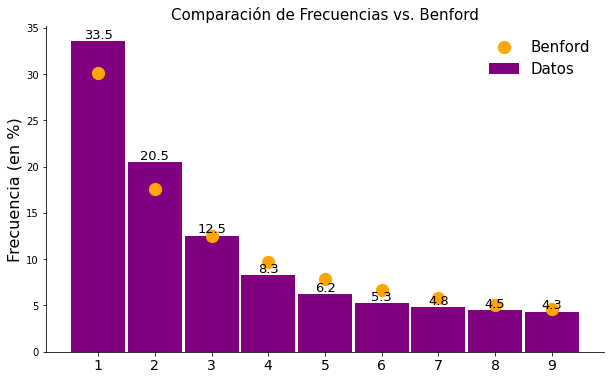

In [23]:
# Importación de librerías
import matplotlib.pyplot as plt

index = [i + 1 for i in range(len(data_count))]

# Grafico de barras.
# Comparación de valores observados vs. esperados del primer digito, en porcentajes.
def bar_chart(data_pct):
    fig, ax = plt.subplots(figsize = (10, 6))
    index = [i + 1 for i in range(len(data_pct))]  # 1st digits for x-axis

    # text for labels, title and ticks
    fig.canvas.set_window_title('Percentage First Digits')
    ax.set_title('Comparación de Frecuencias vs. Benford', fontsize=15)
    ax.set_ylabel('Frecuencia (en %)', fontsize=16)
    ax.set_xticks(index)
    ax.set_xticklabels(index, fontsize=14)

    # build bars
    rects = ax.bar(index, data_pct, width=0.95, color='purple', label='Datos')

    # attach a text label above each bar displaying its height
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height,
                '{:0.1f}'.format(height), ha='center', va='bottom', 
                fontsize=13)

    # plot Benford values as red dots
    ax.scatter(index, BENFORD, s=150, c='orange', zorder=2, label='Benford')

    # Hide the right and top spines & add legend
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(prop={'size':15}, frameon=False)
    plt.show()
    
bar_chart(data_percentage[0:9])

### 8.4. Detección de anomalías utilizando métodos univariados

https://medium.com/analytics-vidhya/anomaly-detection-in-python-part-1-basics-code-and-standard-algorithms-37d022cdbcff

https://towardsdatascience.com/anomaly-detection-in-python-part-2-multivariate-unsupervised-methods-and-code-b311a63f298b

#### 8.4.1. Representaciones gráficas

In [38]:
# Box plot por atributo.
def boxplot_chart(column_name):
    fig, ax = plt.subplots(figsize = (25, 5))
    fig.canvas.set_window_title('Gráfico de caja y bigotes')
    ax.set_title('Gráfico de caja y bigotes: ' + column_name.capitalize(), fontsize = 15)
    ax.boxplot(x = df.loc[:, column_name], vert = False, whis = 2.5, )
    plt.show()

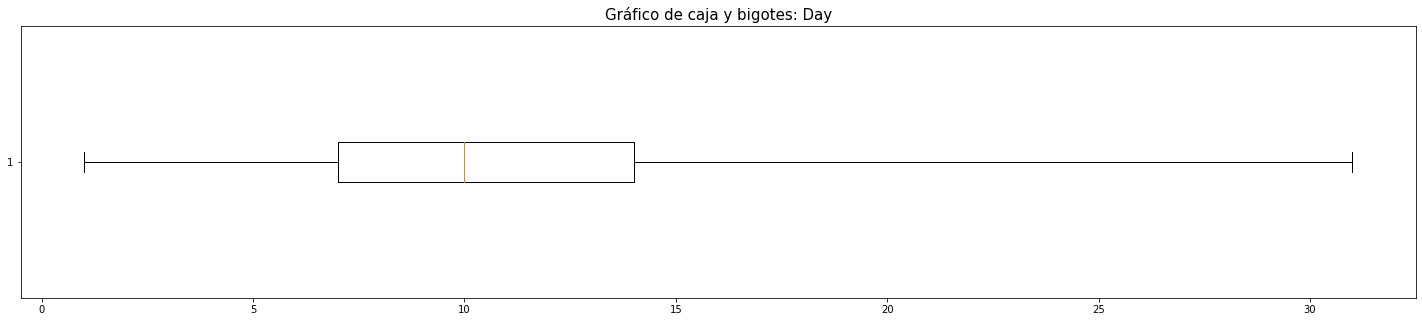

In [39]:
boxplot_chart('day')

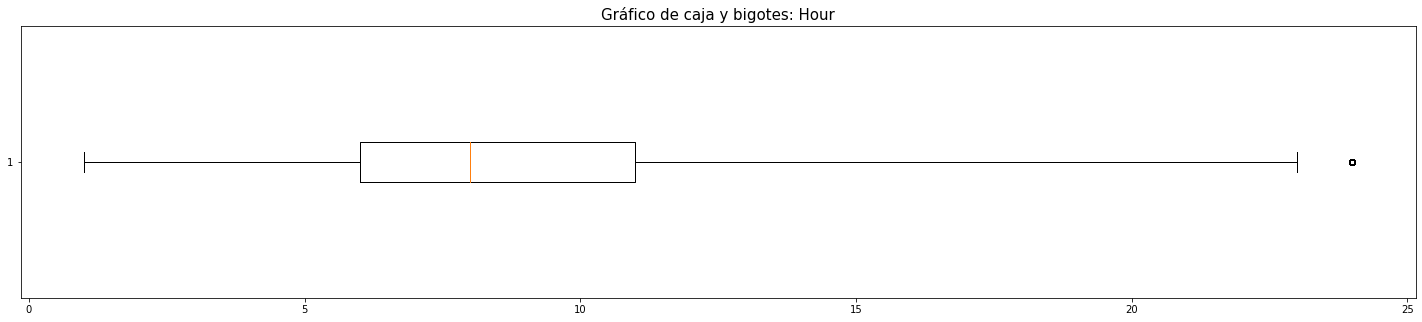

In [40]:
boxplot_chart('hour')

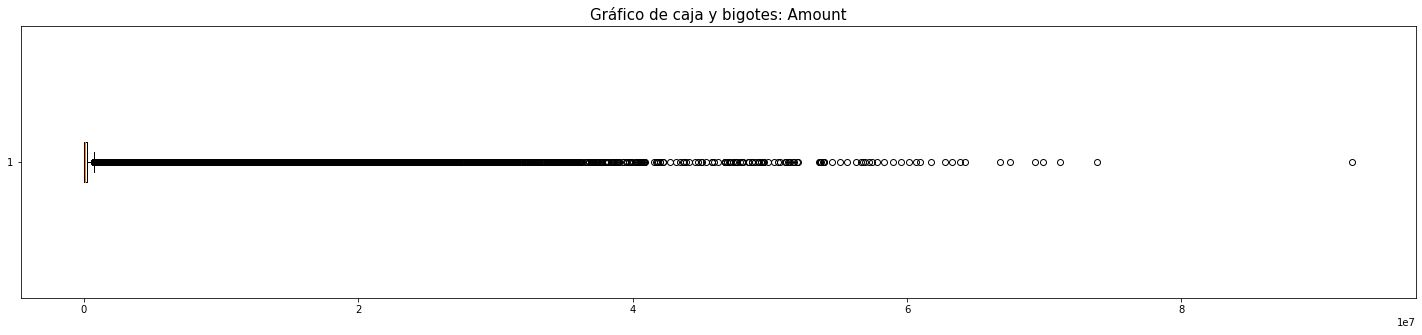

In [41]:
boxplot_chart('amount')

In [42]:
# Histograma por atributo.
def hist_chart(column_name):
    data = df.loc[df.loc[:, 'amount'] <= 100000, 'amount']
    fig, ax = plt.subplots(figsize = (25, 5))
    fig.canvas.set_window_title('Histograma')
    ax.set_title('Histograma: ' + column_name.capitalize(), fontsize = 15)
    ax.set_ylabel('Frequency', fontsize = 16)
    ax.hist(x = data)
    plt.show()

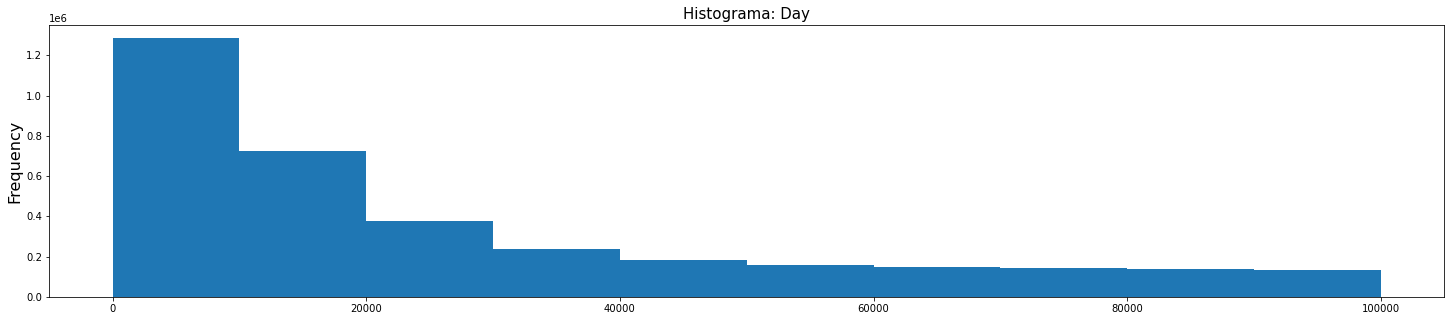

In [43]:
hist_chart('day')

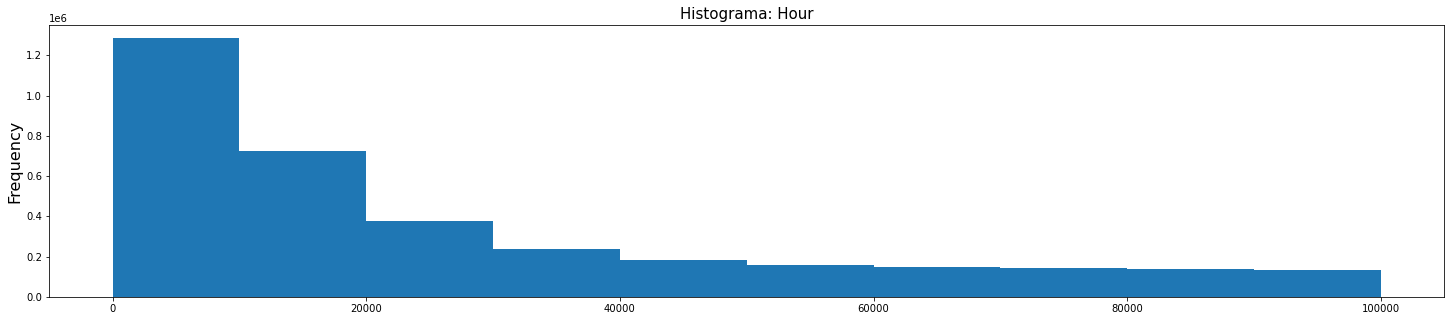

In [44]:
hist_chart('hour')

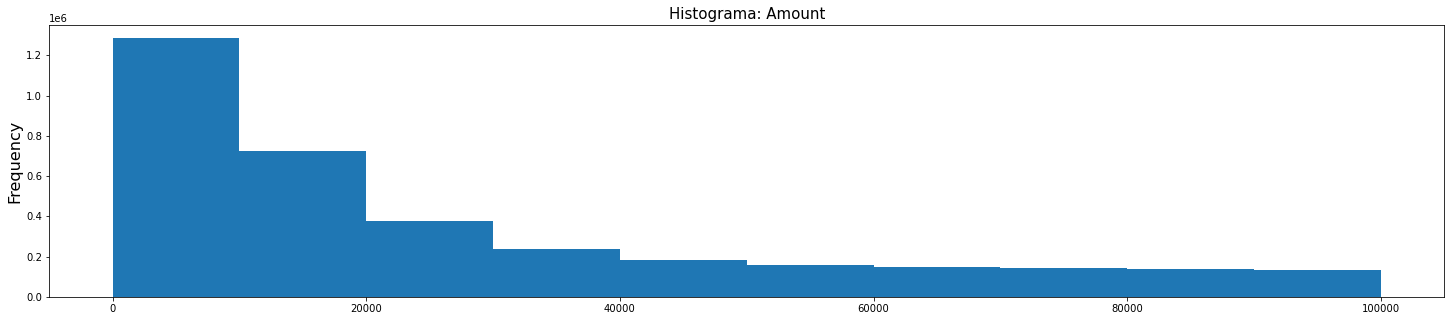

In [45]:
hist_chart('amount')

#### 8.4.2. Método de Tukey

##### 8.4.2.1. Definición

In [6]:
# Función para obtener outliers en base al Método de Tukey.
# Se filtran los registros con monto superior o inferior a 2,5 veces sobre los límites del rango intercuartil.
def tukey(x, k = 2.5):
    x = np.array(x).copy().astype(float)
    first_quartile = np.quantile(x, .25)
    third_quartile = np.quantile(x, .75)
    
    # Rango intercuartil
    iqr = third_quartile - first_quartile
    
    # Definicion de umbrales.
    lower_allowed_limit = first_quartile - (k * iqr)
    upper_allowed_limit = third_quartile + (k * iqr)
    
    # Filtro de registros outliers.
    outliers = (x < lower_allowed_limit) | (x > upper_allowed_limit)
    return outliers

df[tukey(df.amount)].sort_values(by = 'amount', ascending = False)

,day,hour,amount,idOrig,oldbalanceOrig,newbalanceOrig,idDest,oldbalanceDest,newbalanceDest,Cash_in,Cash_out,Debit,Payment,Transfer,isFraud,isFlaggedFraud
3686583,12,9,92445516.64,3683382,0.00,0.0,7135235,9.595980e+03,9.245511e+07,0,0,0,0,1,0,0
4060598,13,10,73823490.36,4056750,0.00,0.0,7244286,9.362401e+07,1.674475e+08,0,0,0,0,1,0,0
4146397,13,10,71172480.42,4142395,0.00,0.0,7094563,1.134615e+08,1.846340e+08,0,0,0,0,1,0,0
3946920,12,10,69886731.30,3943276,0.00,0.0,6683724,1.515387e+08,2.214254e+08,0,0,0,0,1,0,0
3911956,12,10,69337316.27,3908368,0.00,0.0,6780152,1.130072e+08,1.823446e+08,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4775613,14,11,697064.88,4770273,0.00,0.0,6869269,2.550357e+06,3.247422e+06,0,0,0,0,1,0,0
426274,1,1,697062.39,426239,27581.95,0.0,6369957,5.199253e+06,5.463425e+06,0,0,0,0,1,0,0
5317003,16,13,697053.03,5310409,0.00,0.0,7488905,1.267378e+06,1.964431e+06,0,0,0,0,1,0,0
2004210,8,6,697052.14,2003288,24526.84,0.0,7132233,7.966455e+05,1.493698e+06,0,0,0,0,1,0,0


##### 8.4.2.2. Evaluación sobre el conjunto de validación

In [7]:
# Importación de librerías.
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, accuracy_score

y_test = df_validation.loc[:, 'isFraud']
y_pred = [int(i) for i in tukey(df.amount)[df_validation.index]]

print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.3926
Precision: 0.0159
AUC: 0.6806
Accuracy: 0.9678
F1-Score: 0.0305


In [8]:
# Reporte Precision, Recall, F1.
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names = ['Not Fraud', 'Fraud'], digits = 4))

              precision    recall  f1-score   support

   Not Fraud     0.9992    0.9686    0.9836   1270881
       Fraud     0.0159    0.3926    0.0305      1643

    accuracy                         0.9678   1272524
   macro avg     0.5075    0.6806    0.5071   1272524
weighted avg     0.9979    0.9678    0.9824   1272524



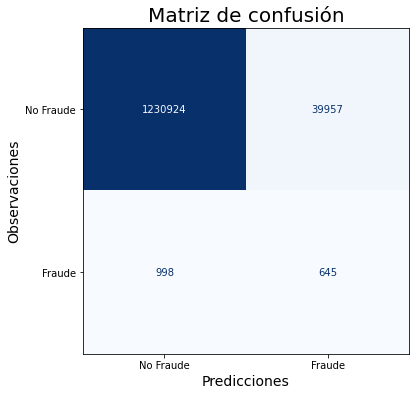

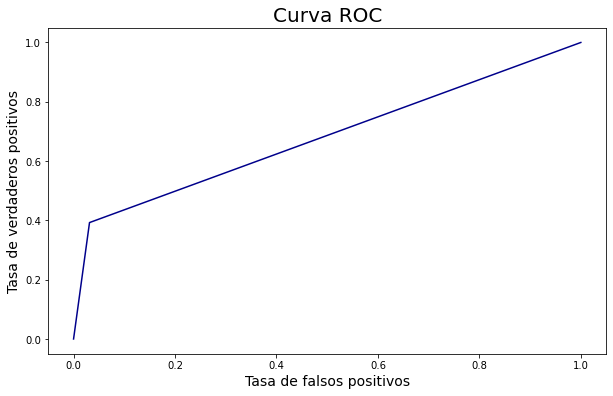

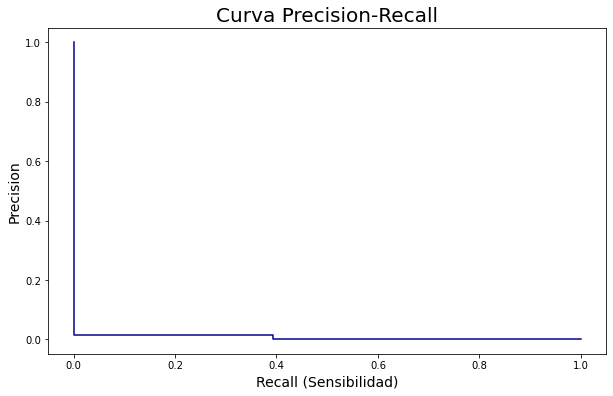

In [9]:
# Exportación a png.
from export import export_png
export_png(filename = 'tukey', y_test = y_test, y_pred = y_pred)

In [11]:
# Creación de paleta de colores.
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

blues_new = np.zeros(shape = (4,4))
blues_new[0, :] = cm.get_cmap('Blues', 100)(25)
blues_new[1, :] = cm.get_cmap('Blues', 100)(50)
blues_new[2, :] = cm.get_cmap('Blues', 100)(75)
blues_new[3, :] = cm.get_cmap('Blues', 100)(100)

blues_cmp = ListedColormap(blues_new)

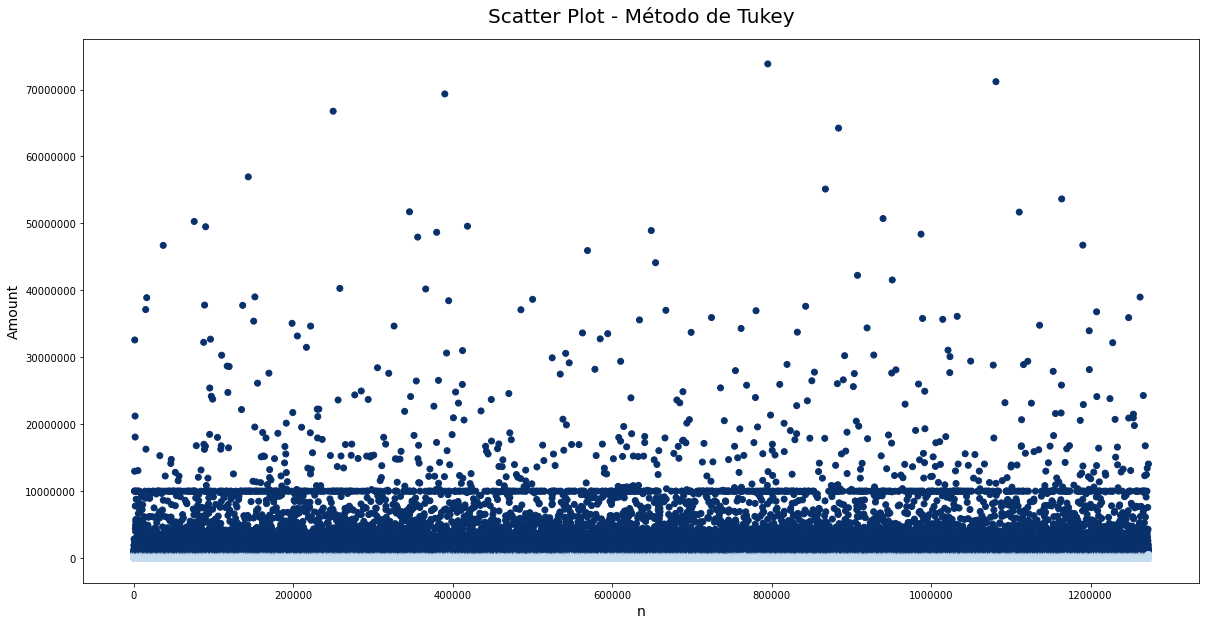

In [12]:
# Scatter plot con predicciones realizadas por el Método de Tukey.
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

df_disp = pd.DataFrame({'amount' : df_validation.amount, 'prediction' : y_pred})
df_disp = df_disp.reset_index()
df_disp = df_disp

fig, ax = plt.subplots(figsize = (20, 10))
fig = plt.scatter(x = df_disp.index, y = df_disp.amount, c = df_disp.prediction, cmap = blues_cmp)
fig = plt.title(label = 'Scatter Plot - Método de Tukey', fontdict = {'fontsize' : 20}, y = 1.02)
ax.set_xlabel('n', fontdict = {'fontsize' : 14})
ax.set_ylabel('Amount', fontdict = {'fontsize' : 14})
ax.xaxis.set_major_formatter(FormatStrFormatter('%i'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%i'))
plt.show()

### 8.5. Detección de anomalías utilizando métodos multivariados

#### 8.5.1. Con determinación del valor de contaminación

In [37]:
# Creación de atributos para medir la diferencia entre los saldos de originantes y destinatarios.
# Justificación: evaluar si la creacion de esta variable y la vinculación con los montos de transacciones permite descubrir patrones ocultos.
df['varOrig'] = df['newbalanceOrig'] - df['oldbalanceOrig']
df['varDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [38]:
# Creacion de dataframe auxiliar.
data = df.loc[:, ['amount', 'varOrig', 'varDest', 'Cash_in', 'Cash_out', 'Debit', 'Payment', 'Transfer']]

In [44]:
# Importacion de librerias.
from sklearn import covariance
# Elliptic Envelope
el = covariance.EllipticEnvelope(store_precision = True, assume_centered = False, support_fraction = None, contamination = 0.0025, random_state = 42)
# Ajuste de datos.
el.fit(data)

EllipticEnvelope(contamination=0.0025, random_state=42)

In [45]:
# Creacion de columna de prediccion de anomalias.
data['anomaly'] = el.predict(data)

In [47]:
# Scatterplot con distincion de casos anómanlos.
def scatter_func(column):
    plt.figure(figsize = (9, 4))
    ax = plt.scatter(data['amount'], data[column], c = data['anomaly'], cmap = 'coolwarm')
    plt.xlabel('amount')
    plt.ylabel(column)
    plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')
    plt.grid()

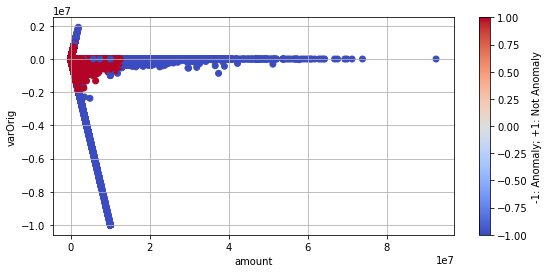

In [48]:
scatter_func('varOrig')

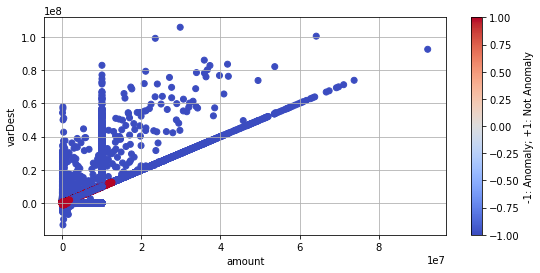

In [49]:
scatter_func('varDest')

#### 8.5.2. Sin determinación del valor de contaminación

Uso de la distancia Mahalanobis para mensurar el caracter de anomalía.

In [51]:
# Importacion de librerias.
from sklearn import covariance
# Creacion de dataframe auxiliar.
data = df.loc[:, ['amount', 'varOrig', 'varDest', 'Cash_in', 'Cash_out',
           'Debit', 'Payment', 'Transfer']]
# Elliptic Envelope
el = covariance.EllipticEnvelope(store_precision = True, assume_centered = False, support_fraction = None, contamination = 0.0025, random_state = 42)
# Ajuste de datos.
el.fit(data)
# Columna para medir la distancia Mahalanobis.
data['Mahalanobis Distance'] = el.mahalanobis(data)

In [52]:
# Scatterplot con distincion de casos anómanlos.
def scatter_func(column):
    plt.figure(figsize = (12, 6))
    ax = plt.scatter(data['amount'], data[column], c = data['Mahalanobis Distance'], cmap = 'coolwarm')
    plt.xlabel('amount')
    plt.ylabel(column)
    plt.colorbar(label = 'Mahalanobis Distance')
    plt.grid()

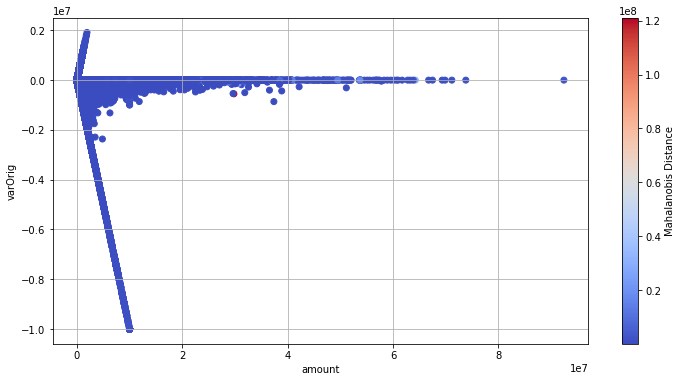

In [53]:
scatter_func('varOrig')

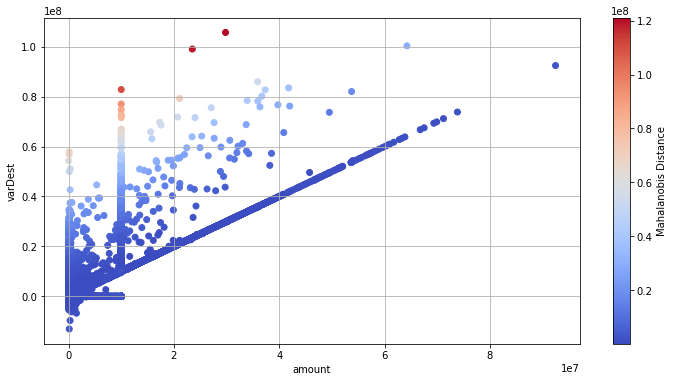

In [54]:
scatter_func('varDest')